# Sparse Linear Inverse with EM Learning

In the [sparse linear inverse demo](./sparse_lin_inverse.ipynb), we saw how to set up a solve a simple sparse linear inverse problem using the `vamp` method in the `vampyre` package.  Specifically, we solved for a vector $x$ from linear measurements of the form $y=Ax+w$.  Critical in demo was that the `vamp` method had to be supplied a description of the statistics on the components on $x$ and the noise variance $w$.  In many practical cases though, these are not known.  In the demo, we show how to simultaneously learn $x$ and the distribution on $x$ with EM learning.

The example here is taken from the following paper which introduced the combination of VAMP with EM learning:
> Fletcher, Alyson K., and Philip Schniter. [Learning and free energies for vector approximate message passing,](http://ieeexplore.ieee.org/abstract/document/7952957/) Proc. IEEE Acoustics, Speech and Signal Processing (ICASSP), 2017.

## Importing the Package 


First, as in the [sparse linear inverse demo](./sparse_lin_inverse.ipynb) we load `vampyre` and other packages.

In [1]:
# Import vampyre
import os
import sys
vp_path = os.path.abspath('../../')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp
from numba import jit

# Import the other packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generating Synthetic Data

Next, we will generate the synthetic sparse data.  Recall, that in the sparse linear inverse problem, we want to estimate a vector $z_0$ from measurements
$$
    y = Az_0 + w,
$$
for some known linear transform $A$.  The vector $w$ represents noise.

The sparse vector $z_0$ is described probabilistically.  We will use a slightly different model than in the sparse linear inverse demo, and describe the sparse vector $z_0$ as a [Gaussian mixture model](https://en.wikipedia.org/wiki/Mixture_model): Each component of the vector $z_0$ is distributed as being randomly one of two components:
$$
    z_{0j} \sim \begin{cases} 
        N(0,\sigma^2_H) & \mbox{with prob } P_H, \\
        N(0,\sigma^2_L) & \mbox{with prob } P_L, 
    \end{cases}
$$
where $\sigma^2_H$ represents a *high* variance and $\sigma^2_L$ a *low* variance.  Thus, with some probability $p_L$, the component is small (close to zero) and probability $p_H$ it is large.  

In [2]:
class em_gamp_det():
# implement em-gamp for my problem
    def __init__(self, n=64, iters=50, threshold=0.20, plot=False, o_s=1):
        self.n = n
        self.iters = iters
        self.o_s = o_s
        self.A = np.fft.fft(np.eye(self.o_s*self.n))[:self.n, :]
        self.threshold = threshold
        self.Aop = vp.trans.MatrixLT(self.A, (self.o_s*self.n,))
        self.plot=plot


    def predict(self, data):
        if len(data.shape) == 1:
            data = data.reshape((1, -1))

        estimates = np.zeros((len(data),))
        for i in range(len(data)):
            y = data[i, :]
            wvar_init = np.mean(np.abs(y)**2)
            meanc_init = np.array([0,0.55])
            prob_hi_init = 0.09
            prob_lo_init = 1-prob_hi_init
            var_hi_init = 0.15
            var_lo_init = 1e-3 
            probc_init = np.array([prob_lo_init, prob_hi_init])
            varc_init = np.array([var_lo_init, var_hi_init])

            # Estimator with EM, initialized to the above values
            est_in_em = vp.estim.GMMEst(shape=(self.o_s*self.n),\
                zvarmin=1e-6,tune_gmm=True,probc=probc_init,meanc=meanc_init, varc=varc_init,is_complex=True,name='GMM input')

            est_out_em = vp.estim.LinEst(self.Aop,y,wvar=0.05,map_est=False,tune_wvar=True, name='Linear+AWGN', is_complex=True)
            msg_hdl = vp.estim.MsgHdlSimp(map_est=False, shape=(self.o_s*self.n,))
            solver = vp.solver.Vamp(est_in_em, est_out_em,msg_hdl,hist_list=['zhat'],nit=self.iters)
            solver.solve()
            zhat = solver.hist_dict['zhat']
            zhat = zhat[-1]
            estimates[i] = np.sum(abs(zhat) > self.threshold)
#             print(zhat)
            if self.plot:
                plt.figure()
                plt.plot(np.arange(1, self.o_s*self.n+1)/self.o_s, np.flip(zhat)>self.threshold)
                plt.title("Est plot")
#                 plt.show()
                
        estimates[estimates > 5] = 5
        estimates[estimates < 1] = 1
        return estimates
my_em = em_gamp_det(o_s=4, plot=True)
print(my_em.predict(y))

NameError: name 'y' is not defined

[ 6.  15.  16.5 20. ]


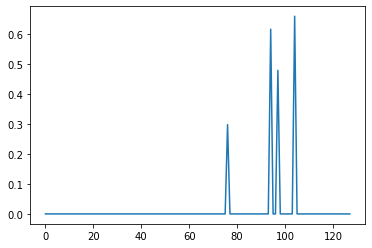

(64, 128)
Final MSE (oracle) = -17.108861 dB


d:\vampyre\vampyre\estim\gmm.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  probc[i] = np.mean(prob_list[i])
d:\vampyre\vampyre\estim\gmm.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  meanc[i] = np.mean(prob_list[i]*zmean_list[i])/probc[i]


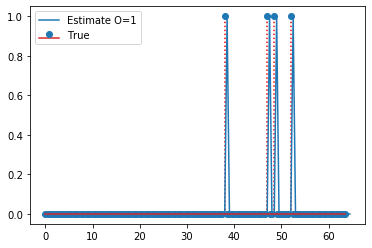

[4.]


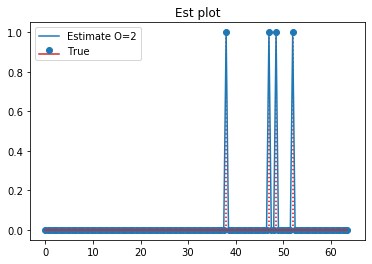

In [3]:
np.random.seed(15)

# Dimensions
nz0 = 128
nz1 = 64
ncol = 1
zshape0 = (nz0,)
zshape1 = (nz1,)

# Parameters for the two components
varc_lo = 0       # variance of the low variance component
varc_hi = 1/12*(0.9)**2          # variance of the high variance component
prob_hi = 3/64        # probability of the high variance component
prob_lo = 1-prob_hi
meanc = np.array([0,0.55])
probc = np.array([prob_lo, prob_hi])    
varc = np.array([varc_lo, varc_hi])
nc = len(probc)    

# Generate random data following the GMM model

# Generate the random input 
# z0_on = np.random.normal(z0_mean_on, np.sqrt(z0_var_on), zshape0)
z0_on = np.random.uniform(0.1, 1, zshape0)
u = np.random.uniform(0, 1, zshape0) < prob_hi
z0 = z0_on*u
z0[:int(nz0/2)] = 0
ind = np.arange(nz0)
# z0 = np.zeros_like(u)
print((np.where(z0>0)[0] / nz0 - 0.5)*64)
plt.plot(ind,z0);
plt.show()

A = np.fft.fft(np.eye(nz0))[:nz1, :]
z1 = A.dot(z0)

snr = 50


a_i = z0[z0>0]
f_i = np.where(z0>0)[0] / nz0
# a_i = [1]
# f_i = [3/64+4/256]

nt = np.arange(nz1)
y = np.zeros([nz1,], dtype=np.complex)
for i in range(len(f_i)):
    y = y + a_i[i] * np.exp(1j*2*np.pi*f_i[i]*nt)
    
# plt.plot(nt, y.real)
# y = 1*(np.real(y+w) > 0) + 1j*(np.imag(y+w)>0)
# plt.plot(nt, y.real)

zvar1 = np.mean(np.abs(y)**2)
wvar = zvar1*np.power(10, -0.1*snr)
w = np.random.normal(0,np.sqrt(wvar/2), zshape1) + 1j*np.random.normal(0,np.sqrt(wvar/2), zshape1)
# plt.plot(y+w)
# plt.show()
y = np.sign(np.real(y+w)) + 1j*np.sign(np.imag(y+w))

# Initial estimate for the noise
wvar_init = np.mean(np.abs(y)**2)

# Intiial estimates for the component means, variances and probabilities
meanc_init = np.array([0,0.5])
prob_hi_init = 0.08
prob_lo_init = 1-prob_hi_init
var_hi_init = 0.2
var_lo_init = 1e-4 
probc_init = np.array([prob_lo_init, prob_hi_init])
varc_init = np.array([var_lo_init, var_hi_init])

# Estimator with EM, initialized to the above values
est_in_em = vp.estim.GMMEst(shape=zshape0,\
    zvarmin=1e-6,tune_gmm=True,probc=probc_init,meanc=meanc_init, varc=varc_init,is_complex=True,name='GMM input')

# No auto-tuning.  Set estimators with the true values
est_in_oracle = vp.estim.GMMEst(shape=zshape0, probc=probc, meanc=meanc, varc=varc, tune_gmm=False,name='GMM input')

Aop = vp.trans.MatrixLT(A,zshape0)
print(A.shape)
map_est = False
est_out_em     = vp.estim.LinEst(Aop,y,wvar=wvar_init,is_complex=True,map_est=map_est,tune_wvar=True, name='Linear+AWGN')
est_out_oracle = vp.estim.LinEst(Aop,y,wvar=wvar,map_est=map_est,tune_wvar=False, name='Linear+AWGN')

# Create the message handler
msg_hdl = vp.estim.MsgHdlSimp(map_est=map_est, shape=zshape0)

# Create the solver
nit = 50
solver = vp.solver.Vamp(est_in_em, est_out_em,msg_hdl,hist_list=['zhat'],nit=nit) 

# Run the solver
solver.solve()

# Get the estimation history
zhat_hist = solver.hist_dict['zhat']
nit2 = len(zhat_hist)
zpow = np.mean(np.abs(z0)**2)

mse_oracle = np.zeros(nit2)
for it in range(nit2):
    zhati = np.flip(zhat_hist[it])
    zerr = np.mean(np.abs(zhati-z0)**2)
    mse_oracle[it] = 10*np.log10(zerr)
    
# Print final MSE
print("Final MSE (oracle) = {0:f} dB".format(mse_oracle[-1]))

zhat0 = zhat_hist[-1]
ind = np.array(range(nz0))/(nz0/nz1)
plt.plot(ind+1,np.flip(abs(zhat0)>0.2))
plt.stem(ind,z0>0, ':r', use_line_collection=True)
plt.legend(['Estimate O=1', 'True']);
plt.show()

my_em = em_gamp_det(o_s=2, plot=True)
print(my_em.predict(y))
plt.stem(ind,z0>0, ':r', use_line_collection=True)
plt.legend(['Estimate O=2', 'True']);
plt.show()

# my_em = em_gamp_det(o_s=4, plot=True)
# print(my_em.predict(y))
# plt.stem(ind,z0>0, ':r', use_line_collection=True)
# plt.legend(['Estimate O=4', 'True']);
# plt.show()

Starting 1/15
Starting 2/15
Starting 3/15
Starting 4/15
Starting 5/15
Starting 6/15
Starting 7/15
Starting 8/15
Starting 9/15
Starting 10/15
Starting 11/15
Starting 12/15
Starting 13/15
Starting 14/15
Starting 15/15


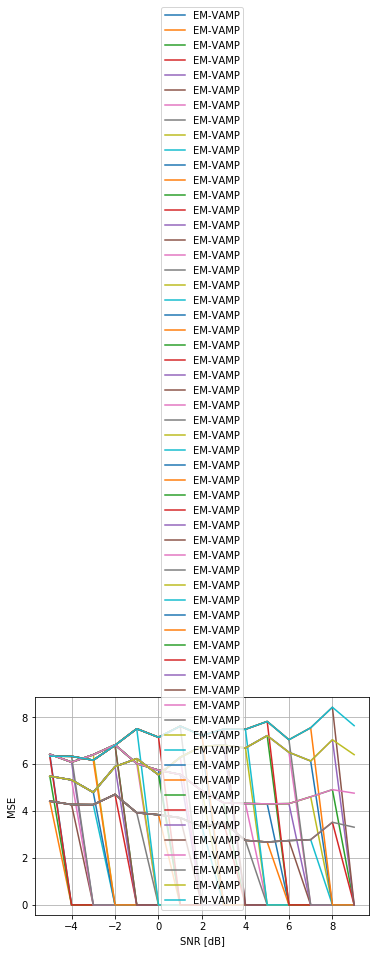

In [4]:
MC = 200
snrs = np.arange(-5, 10)
losses = np.zeros([MC, len(snrs)])
# thresholds = np.linspace(0.19, 0.23, 4)
thresholds = np.array([0.2])


zshape0 = 128
zshape1 = 64
nt = np.arange(zshape1)
# @jit(nopython=True, cache=True)
def one_test(A, snr):
#     z0_on = np.random.uniform(0.1, 1, zshape0)
#     u = np.random.uniform(0, 1, zshape0) < prob_hi
#     z0 = z0_on*u
#     z0[:int(nz0/2)] = 0
#     zvar1 = np.abs(1.0)**2
#     wvar = zvar1*np.power(10, -0.1*snr)
#     w = np.random.normal(0,np.sqrt(wvar/2), zshape1) + 1j*np.random.normal(0,np.sqrt(wvar/2), zshape1)
#     a_i = z0[z0>0]
#     f_i = np.where(z0>0)[0] / nz0
    m = np.random.randint(1, 5)
    a_i = np.random.uniform(0.1, 1, m)
#     f_i = np.random.uniform(0.001, 0.5, m)
    w = abs(np.sqrt(2.5/64)*np.random.randn(m,))
    f_i = []
    start = np.random.uniform(0.001, 0.25)
    for k in range(len(w)): # ensure all points are more than 1/n apart
        f_i.append(start+(1+k)/64+w[k])
    while np.max(f_i) > 0.49:
            # in case any happen to get a poor split
            w = abs(np.sqrt(2.5/64)*np.random.randn(m,))
            start = np.random.uniform(0.001, 0.25)
            f_i = [start]
            for k in range(len(w)-1): # ensure all points are more than 1/n apart
                f_i.append(start+(1+k)/64+w[k])
            # print("Redrawing freqs, too high of frequency selected")

    f_i.sort()

    y = np.zeros((zshape1,), dtype=np.complex128)
#     phi_i = np.random.uniform(0, 2*np.pi, len(f_i))
    phi_i = np.zeros_like(f_i)
    for i in range(len(f_i)):
        y = y + a_i[i] * np.exp(1j*2*np.pi*f_i[i]*nt + phi_i[i])

    py = np.mean(np.abs(y)**2)
    y = y/py
    pw = np.power(10, -0.1*snr)
    noise = np.random.normal(0,np.sqrt(pw/2), (zshape1,)) + 1j*np.random.normal(0,np.sqrt(pw/2), (zshape1,))
    y = np.sign(np.real(y+noise)) + 1j*np.sign(np.imag(y+noise))
    y_true = len(f_i)
    return y, y_true


losses = np.zeros([MC, len(snrs), 4])
thresholds = [1, 2, 4, 8]
my_em1 = em_gamp_det(threshold=0.2, n=64, o_s=1, iters=25)
my_em2 = em_gamp_det(threshold=0.2, n=64, o_s=2, iters=25)
my_em4 = em_gamp_det(threshold=0.2, n=64, o_s=4, iters=25)
my_em8 = em_gamp_det(threshold=0.2, n=64, o_s=8, iters=25)
my_ems = [my_em1, my_em2, my_em4, my_em8]

for k, snr in enumerate(snrs):
    print(f"Starting {(k+1)}/{len(snrs)}")
    for i in range(MC):
        y, y_true = one_test(A, snr)
        for b in range(len(my_ems)):
            losses[i, k, b] = abs(y_true - my_ems[b].predict(y))**2

    plt.plot(snrs, np.mean(losses, axis=0), label='EM-VAMP')
plt.legend()
plt.xlabel("SNR [dB]")
plt.ylabel("MSE")
plt.grid()
plt.show()

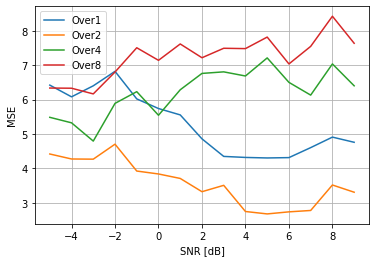

In [5]:
for k in range(len(my_ems)):
    plt.plot(snrs, np.mean(losses, axis=0)[:, k], label=f'Over{thresholds[k]}')
plt.legend()
plt.xlabel("SNR [dB]")
plt.ylabel("MSE")
plt.grid()
plt.show()

Next, we generate a random matrix.  Before, we generated the random matrix with Gaussian iid entries.  In this example, to make the problem more challenging, we will use a more ill-conditioned random matrix.  The method `rand_rot_invariant` creates a random matrix with a specific condition number.

In [3]:
# Create the message handler
msg_hdl = vp.estim.MsgHdlSimp(map_est=map_est, shape=zshape0)

# Create the solver
solver = vp.solver.Vamp(est_in_em, est_out_em, msg_hdl,hist_list=['zhat'],nit=nit)       

# Run the solver
solver.solve()

# Get the estimation history
zhat_hist = solver.hist_dict['zhat']
nit2 = len(zhat_hist)
zpow = np.mean(np.abs(z0)**2)

mse_em = np.zeros(nit2)
for it in range(nit2):
    zhati = zhat_hist[it]
    zerr = np.mean(np.abs(zhati-z0)**2)
    mse_em[it] = 10*np.log10(zerr/zpow)
    
# Print final MSE
print("Final MSE (EM) = {0:f} dB".format(mse_em[-1]))  

t = np.arange(nit2)
plt.plot(t,mse_oracle,'o-')
plt.plot(t,mse_em,'s-')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('MSE (dB)')
plt.legend(['Oracle', 'EM'])
plt.show()

Finally, we add noise at the desired SNR

[0.53125  0.765625]


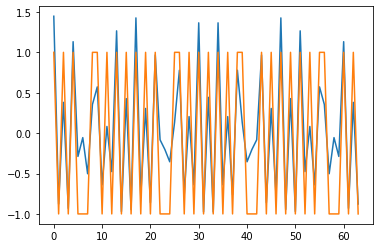

## Set up the solvers 

As in the sparse inverse demo, the VAMP estimator requires that we specify two probability distributions:
* Prior:  $p(z_0|\theta_0)$;
* Likelihood:  $p(y|z_0,\theta_1)$.
In this case, both densities depend on *parameters*: $\theta_0$ and $\theta_1$.  For the prior, the parameters $\theta_0$ represent the parameters of the components `(probc,meanc,varc)`.  For the likelihood, the unknown parameter $\theta_1$ is the output variance `wvar`.

EM estimation is a method that allows to learn the values of the parameters $\theta_0$ and $\theta_1$ while also estimating the vector $z_0$.

EM estimation is an iterative technique and requires that we specify initial estimates for the unknown parameters: `wvar,probc,meanc,varc`.  We will use the initialization in the paper above.

To evaluate the EM method, we will compare it against an *oracle* that knows the true density.  We thus create two estimators for the prior:  one for the oracle that is set to the true GMM parameters with tuning disabled (`tune_gmm=False`); and one for the EM estimator where the parameters are set to the initial estimators and tuning enabled (`tune_gmm=True`).

We also create two estimators for the likelihood $p(y|z1,wvar)$.  For the oracle estimator, the parameter `wvar` is set to its true value; for the EM estimator it is set to its initial estimate `wvar_init`.

## Running the solvers for the oracle and EM case

We first run the solver for the oracle case and measure the MSE per iteration.

Final MSE (oracle) = 4.379911 dB


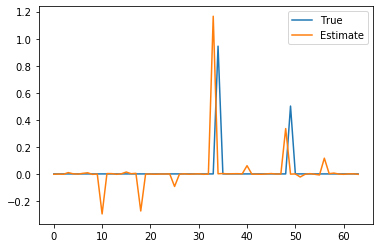

Next, we run the EM estimator.  We see we obtain a similar final MSE.

Final MSE (EM) = 3.900587 dB


d:\vampyre\vampyre\estim\gmm.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  probc[i] = np.mean(prob_list[i])
d:\vampyre\vampyre\estim\gmm.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  meanc[i] = np.mean(prob_list[i]*zmean_list[i])/probc[i]


We plot the two MSEs as a function of the iteration number.

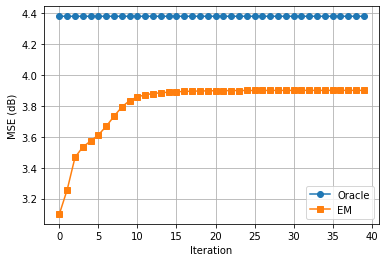

We see that the EM algorithm is eventually able to obtain the same MSE, but with a few more iterations.